# Exercise 18: Analysis of Temperatures

In [39]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from scipy.signal import lombscargle
from scipy.interpolate import interp1d 
from scipy.fft import fft, fftfreq, ifft

## a) Read the file and inspect it

In [40]:
# Load the data
df = pd.read_csv('Temperaturdaten_Dortmund.csv')

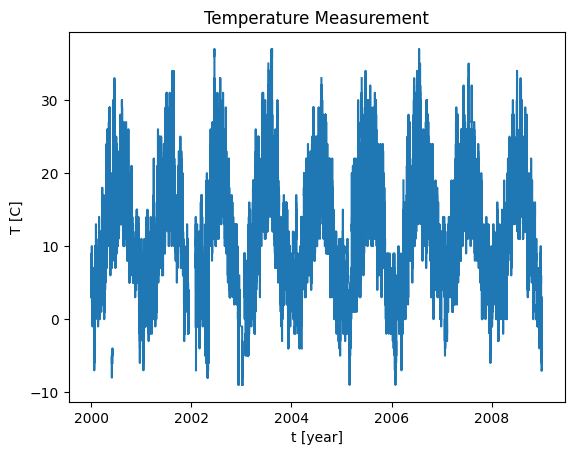

In [41]:
# Plot the temperature data
plt.plot(df['Messzeit'], df['Temperatur'])
plt.xlabel('t [year]')
plt.ylabel('T [C]')
plt.title('Temperature Measurement')
plt.savefig('Temperaturplot.pdf')

In [42]:
# Check for missing values
num_nan = df.isna().sum().sum()
print("Number of NaN values:", num_nan)

# Drop missing values
df = df.dropna()

Number of NaN values: 20273


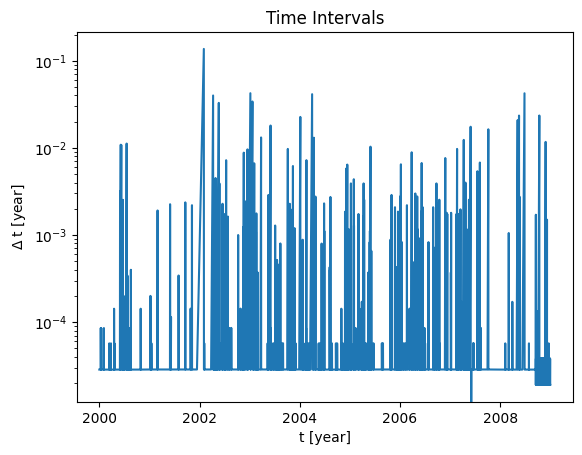

In [43]:
# Check time intervals
plt.figure()
plt.plot(df['Messzeit'], df['Messzeit'].diff(), '-')
plt.xlabel('t [year]')
plt.ylabel('$\Delta$ t [year]')
plt.yscale('log')
plt.title('Time Intervals')
plt.savefig('TimeDifference.pdf')

#### The Fourier transform is complex due to unequal time intervals in the data. 
#### Gridding could be an option to overcome this, but it might degrade the results :(

#### The Lomb-Scargle method should work :)

## b) Data Preparation

In [44]:
# Convert to numpy array
T = df['Temperatur'].to_numpy()
t = df['Messzeit'].to_numpy()

In [45]:
# Center the temperature distribution around T=0
T_centered = T - np.mean(T)
if np.mean(T_centered) > 1e-6:
    print('Error: Data is not properly centered')

## c) Lomb-Scargle Periodogram

In [46]:
# Lomb-Scargle Periodogram
delta_t = 15 / (365*24*60) # Abstand zwischen Messwerten
Delta_t = t[-1] - t[0] # Messzeitraum 

f_min = 1 / Delta_t
f_max = 1 / (2 * delta_t)

#### We expect to find peak frequencies corresponding to daily and annual cycles, indicating predominant periodicities of 1 day and 1 year in the data

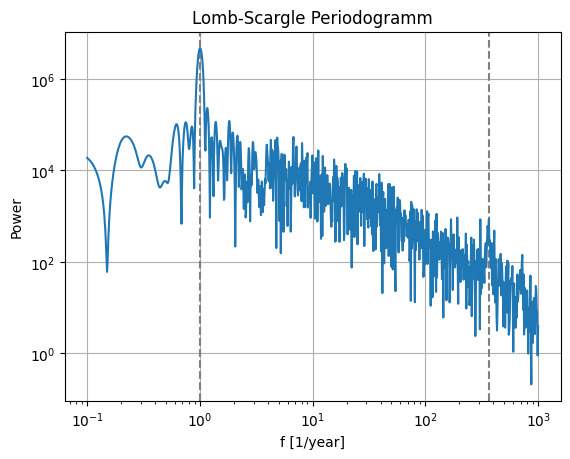

In [47]:
frequenzen = np.logspace(np.log10(0.1), np.log10(1000), num=1000)
power = lombscargle(t, T_centered, 2*np.pi*frequenzen)
plt.figure()
plt.axvline(x=1, color='gray', linestyle='--', label='1 Year')
plt.axvline(x=365, color='gray', linestyle='--', label='1 Day')
plt.plot(frequenzen, power)
plt.xlabel('f [1/year]')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('Lomb-Scargle Periodogramm')
plt.savefig('Lomb-Scargle.pdf')

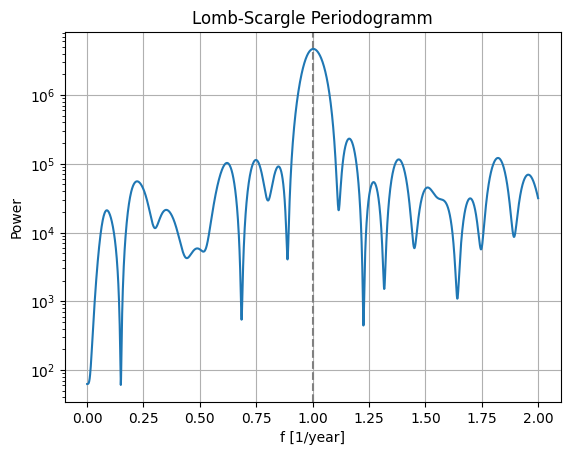

In [48]:
frequenzen = np.arange(0.001, 2, 0.001)
power = lombscargle(t, T_centered, 2*np.pi*frequenzen)
plt.figure()
plt.axvline(x=1, color='gray', linestyle='--', label='1 Year')
plt.plot(frequenzen, power)
plt.xlabel('f [1/year]')
plt.ylabel('Power')
plt.yscale('log')
plt.grid()
plt.title('Lomb-Scargle Periodogramm')
plt.savefig('Lomb-Scargle_year.pdf')

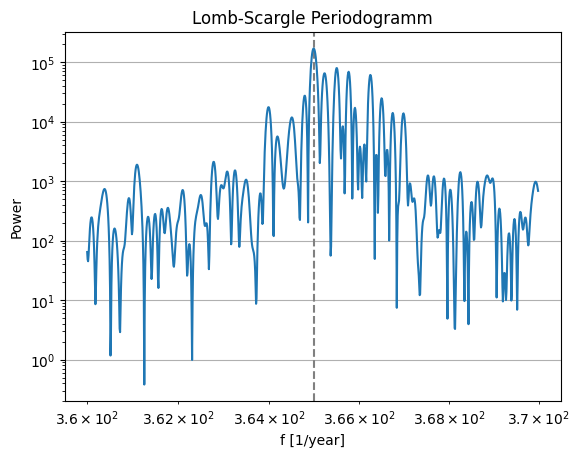

In [49]:
frequenzen = np.arange(360, 370, 0.01)
power = lombscargle(t, T_center, 2*np.pi*frequenzen)
plt.figure()
plt.axvline(x=365, color='gray', linestyle='--', label='1 Day')
plt.plot(frequenzen, power)
plt.xlabel('f [1/year]')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('Lomb-Scargle Periodogramm')
plt.savefig('Lomb-Scargle_day.pdf')

## d) Fourier Trafo

In [50]:
# Interpolate the data onto a regular grid
t_reg = np.linspace(t.min(), t.max(), num=len(t))
interpolator = interp1d(t, T_centered, kind='linear')
T_reg = interpolator(t_reg)

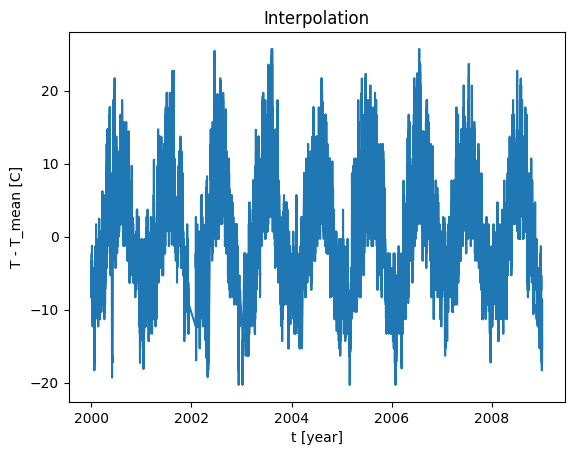

In [51]:
plt.figure()
plt.title('Interpolation')
plt.plot(t_reg, T_reg)
plt.xlabel("t [year]")
plt.ylabel("T - T_mean [C]")
plt.savefig("Interpolation.pdf")

In [52]:
# Compute the FFT and frequencies
fft_result = fft(T_reg)
fft_freq = fftfreq(len(T_reg), d=(t_reg[1] - t_reg[0]))
# Only interested in the positive half of the spectrum
n = len(fft_freq) // 2


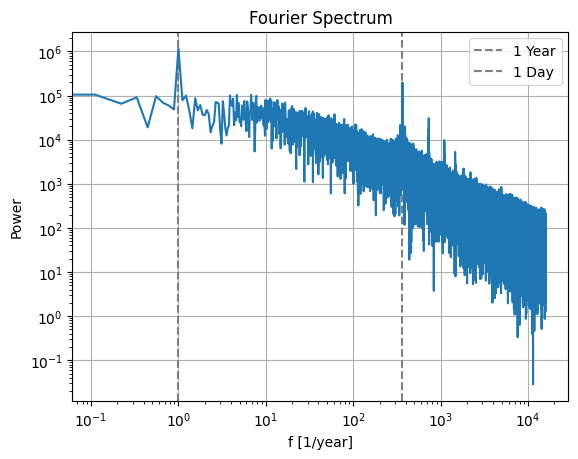

In [53]:
# Plot the frequency spectrum
plt.figure()
plt.axvline(x=1, color='gray', linestyle='--', label='1 Year')
plt.axvline(x=365, color='gray', linestyle='--', label='1 Day')
plt.plot(fft_freq[:n], np.abs(fft_result[:n]))
plt.xlabel('f [1/year]')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('Fourier Spectrum')
plt.legend()
plt.savefig('FourierSpectrum.pdf')

## e) Retransformation of the two maximal frequencies

In [54]:
# Isolate the two maximal frequencies (excluding the direct current (DC) component)
indices = np.argsort(np.abs(fft_result[1:n]))[-2:] + 1  # +1 to skip the DC component

# Isolate the peaks
fft_filtered = np.zeros_like(fft_result)
fft_filtered[indices] = fft_result[indices]
fft_filtered[-indices] = fft_result[-indices]  # Include conjugate frequencies for inverse transform


In [55]:
# Inverse transform
T_filtered = ifft(fft_filtered)

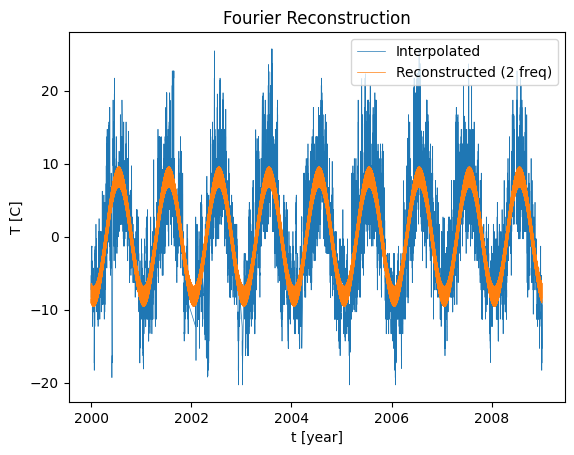

In [56]:
# Plot the reconstructed time series along with the original data
plt.figure()
plt.plot(t_reg, T_reg, label='Interpolated', linewidth=0.5)
plt.plot(t_reg, T_filtered.real, label='Reconstructed (2 freq)', linestyle='-', linewidth=0.5)
plt.xlabel('t [year]')
plt.ylabel('T [C]')
plt.title('Fourier Reconstruction')
plt.legend()
plt.savefig('FourierReconstruction.pdf')